<h1>Movie Stack Exchange Time Series Analysis</h1>


## Introduction

Stack Exchange is a network of question-and-answer (Q&A) websites on topics in diverse fields, each site covering a specific topic, where questions, answers, and users are subject to a reputation award process.

This dataset can be downloaded from here: https://archive.org/download/stackexchange/movies.stackexchange.com.7z

In this notebook, I will:
* Parse time from textual data
* Use a datetime index to slice and filter to specific time periods
* Resample data to various temporal resolutions (daily, weekly, monthly, etc.) and discover periodic trends
* Use a moving window to eliminate noise from a trend

## Import the data

### Import libraries: 


In [205]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
import calendar
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns 
%config InlineBackend.figure_format = 'svg'
import xmltodict


The Stack Overflow data comes as XML. xmltodict takes an XML file and produces a dictionary.

In [206]:
xml_data = open("/Users/huykha/Downloads/movies.stackexchange.com/Posts.xml").read()

stack_dict = xmltodict.parse(xml_data)

Since we have converted the XML file to a dictionary, we can now use json_normalize() to get the Stack Exchange data into a table.

In [207]:
stack_df = pd.json_normalize(stack_dict["posts"]["row"])
stack_df.head

<bound method NDFrame.head of           @Id @PostTypeId @AcceptedAnswerId            @CreationDate @Score  \
0           1           1              2776  2011-11-30T19:15:54.070     32   
1           2           2               NaN  2011-11-30T19:37:10.510     15   
2           3           1               814  2011-11-30T19:41:14.960     29   
3           4           1               120  2011-11-30T19:42:45.470     59   
4           6           1                21  2011-11-30T19:44:55.593     16   
...       ...         ...               ...                      ...    ...   
65064  122376           2               NaN  2024-03-30T07:27:16.777     23   
65065  122377           2               NaN  2024-03-30T10:07:04.903     11   
65066  122378           2               NaN  2024-03-30T18:05:33.640      1   
65067  122379           2               NaN  2024-03-30T20:37:24.103     -1   
65068  122380           2               NaN  2024-03-31T14:29:34.700     -1   

      @ViewCount     

Quick summaries of the dataset:

In [208]:
stack_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65069 entries, 0 to 65068
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   @Id                     65069 non-null  object
 1   @PostTypeId             65069 non-null  object
 2   @AcceptedAnswerId       13887 non-null  object
 3   @CreationDate           65069 non-null  object
 4   @Score                  65069 non-null  object
 5   @ViewCount              22924 non-null  object
 6   @Body                   65069 non-null  object
 7   @OwnerUserId            63115 non-null  object
 8   @LastEditorUserId       40838 non-null  object
 9   @LastEditDate           41536 non-null  object
 10  @LastActivityDate       65069 non-null  object
 11  @Title                  22924 non-null  object
 12  @Tags                   22924 non-null  object
 13  @AnswerCount            22924 non-null  object
 14  @CommentCount           65069 non-null  object
 15  @C

In [209]:
# Remove the @ in the column names
stack_df.columns = [i.replace("@","") for i in stack_df.columns]


In [210]:
# Print the first row 
stack_df.loc[0]

Id                                                                       1
PostTypeId                                                               1
AcceptedAnswerId                                                      2776
CreationDate                                       2011-11-30T19:15:54.070
Score                                                                   32
ViewCount                                                             8718
Body                     <p>Some comedians / actors are given creative ...
OwnerUserId                                                             11
LastEditorUserId                                                     94442
LastEditDate                                       2022-02-12T21:59:39.633
LastActivityDate                                   2022-02-12T21:59:39.633
Title                    To what extent were the actors in Wedding Cras...
Tags                                                    |wedding-crashers|
AnswerCount              

### Setting an index


In [211]:
stack_df.columns

Index(['Id', 'PostTypeId', 'AcceptedAnswerId', 'CreationDate', 'Score',
       'ViewCount', 'Body', 'OwnerUserId', 'LastEditorUserId', 'LastEditDate',
       'LastActivityDate', 'Title', 'Tags', 'AnswerCount', 'CommentCount',
       'ContentLicense', 'ParentId', 'FavoriteCount', 'LastEditorDisplayName',
       'OwnerDisplayName', 'ClosedDate', 'CommunityOwnedDate'],
      dtype='object')

In this table, the column Id is a unique identifier that refers to each post or reply. Since this is unique per row and is related to the post itself, we will make this column the index. The index will then be a label rather than an arbitrary number.

In [212]:
# Set ID as index
stack_df.set_index('Id', inplace=True)

## Data Wrangling

### Handling missing data


In [213]:
len(stack_df["OwnerDisplayName"].unique())

478

In [214]:
stack_df["OwnerDisplayName"].unique()[0:5]

array([nan, 'user96', 'user35', 'user223', 'user315'], dtype=object)

In [ ]:
stack_df["OwnerDisplayName"].fillna("",inplace=True)

In this step, I only use stack_df["OwnerDisplayName"].fillna() rather than stack_df.fillna() because I don't want to fill the np.nan values for the other columns right now. We might want to replace some of these columns with a different value, such as 0.

<h3>Clean numeric data</h3>


In [216]:
stack_df[stack_df.columns].head()

,PostTypeId,AcceptedAnswerId,CreationDate,Score,ViewCount,Body,OwnerUserId,LastEditorUserId,LastEditDate,LastActivityDate,...,Tags,AnswerCount,CommentCount,ContentLicense,ParentId,FavoriteCount,LastEditorDisplayName,OwnerDisplayName,ClosedDate,CommunityOwnedDate
Id,,,,,,,,,,,,,,,,,,,,,
1,1,2776,2011-11-30T19:15:54.070,32,8718,<p>Some comedians / actors are given creative ...,11,94442,2022-02-12T21:59:39.633,2022-02-12T21:59:39.633,...,|wedding-crashers|,2,0,CC BY-SA 4.0,NaN,NaN,NaN,,NaN,NaN
2,2,NaN,2011-11-30T19:37:10.510,15,NaN,"<p>According to the <a href=""http://www.imdb.c...",31,NaN,NaN,2011-11-30T19:37:10.510,...,NaN,NaN,3,CC BY-SA 3.0,1,NaN,NaN,,NaN,NaN
3,1,814,2011-11-30T19:41:14.960,29,1970,"<p>In his Star Wars Episode 1 <a href=""https:/...",41,70064,2019-05-15T02:23:45.307,2019-05-15T02:23:45.307,...,|analysis|star-wars|,2,2,CC BY-SA 4.0,NaN,NaN,NaN,,NaN,NaN
4,1,120,2011-11-30T19:42:45.470,59,4271,<p>I'm a big fan of the Pink Panther movies (t...,22,22,2013-08-17T20:17:23.187,2020-11-18T17:05:17.490,...,|comedy|the-pink-panther|,5,2,CC BY-SA 3.0,NaN,NaN,NaN,,NaN,NaN
6,1,21,2011-11-30T19:44:55.593,16,8476,"<p>At the end of the movie, adult Jack (Sean P...",34,49,2013-06-06T12:05:01.613,2013-06-06T20:02:04.800,...,|plot-explanation|analysis|ending|the-tree-of-...,2,0,CC BY-SA 3.0,NaN,NaN,NaN,,NaN,NaN


We can change a string into a number with pandas.to_numberic

In [238]:
for col in ["Score", "ViewCount", "AnswerCount", "CommentCount", "FavoriteCount"]:
    stack_df[col] = pd.to_numeric(stack_df[col], errors="coerce")
    
print(stack_df['Score'].mean())

7.249273847761607


In [218]:
stack_df.describe().style.format("{:0.2f}") # format("{:0.2f}") display floats with 2 decimals

,Score,ViewCount,AnswerCount,CommentCount,FavoriteCount
count,65069.00,22924.00,22924.00,65069.00,4885.00
mean,7.25,7864.40,1.64,1.59,0.00
std,11.65,29653.20,1.44,2.46,0.02
min,-24.00,10.00,0.00,0.00,0.00
25%,1.00,452.00,1.00,0.00,0.00
50%,4.00,1501.00,1.00,1.00,0.00
75%,9.00,5288.00,2.00,2.00,0.00
max,327.00,1532988.00,19.00,45.00,1.00


By subtracting the range of the dataset with the count of each columns, we get the total missing rows of each columns.

In [219]:
tot = len(stack_df)

for col in ["Score", "ViewCount", "AnswerCount", "CommentCount", "FavoriteCount"]:
    print(f"Missing rows for {col}:", tot - stack_df[col].count())

Missing rows for Score: 0
Missing rows for ViewCount: 42145
Missing rows for AnswerCount: 42145
Missing rows for CommentCount: 0
Missing rows for FavoriteCount: 60184


The fact that ViewCount and AnswerCount both have exactly the same number of missing data suggests that the data is likely missing structurally.

<h3>Parsing time</h3>

<p>There are several columns in the Stack Exchange data that appear to express a specific time. They are presently stored as strings. This include CreationDate, LastEditDate, LastActivityDate, ClosedDate, and CommunityOwnedDate. Transforming the data from a string to a datetime object can be done using pd.to_datetime().</p>


In [220]:
for col in ["CreationDate", "LastEditDate", "LastActivityDate", "ClosedDate", "CommunityOwnedDate"]:
    stack_df[col] = pd.to_datetime(stack_df[col])

    print(f"Number of missing for {col}: ", len(stack_df)-stack_df[col].count())

Number of missing for CreationDate:  0
Number of missing for LastEditDate:  23533
Number of missing for LastActivityDate:  0
Number of missing for ClosedDate:  62973
Number of missing for CommunityOwnedDate:  64999


<h3>Time slicing</h3>


In [221]:
# Slice time by year
year = 2016
cyear = len(stack_df[stack_df["CreationDate"].dt.year == year])
print(f"There were {cyear} posts created in {year}")

There were 9541 posts created in 2016


In [222]:
# Slice time for one specific day
t1 = '2015-03-14'; t2 = '2015-03-15'
mask = (stack_df["CreationDate"]>= t1) & \
       (stack_df["CreationDate"]< t2)
print(f"There were {len(stack_df[mask])} posts made between", f"{t1} and {t2}")

There were 22 posts made between 2015-03-14 and 2015-03-15


## Time-series Analysis

<h4>Distribution of number of posts created from 2012 to 2022 on the Movie Stack Exchange</h4>


Let's use histplot from seaborn. This automatically chunk up the data by time and present some meaningful ticks along the x-axis.


Text(0.5, 1.0, 'Distribution of number of posts created from 2012 to 2022 on the Movie Stack Exchange')

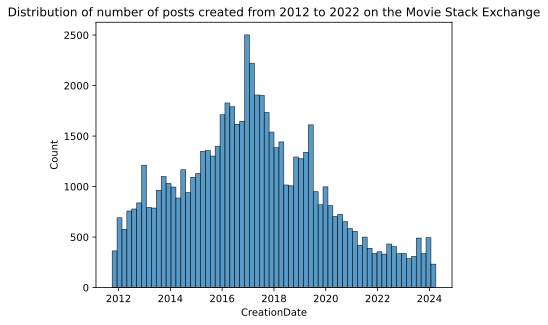

In [224]:
sns.histplot(stack_df["CreationDate"])

plt.title('Distribution of number of posts created from 2012 to 2022 on the Movie Stack Exchange')

<p>As shown in figure above, seaborn chunked up the data in a way that looked like about five or six bins per year, but they were not entirely clear. However, it is more granular than merely one bin per year.</p>

<p>For example, let's take a look at the spike in early 2019. If we had coarsened data, such as binned by year, we might miss a spike like that.</p>

Text(0.5, 1.0, 'Distribution of number of posts created from 2012 to 2022 on the Movie Stack Exchange, coarsened to year')

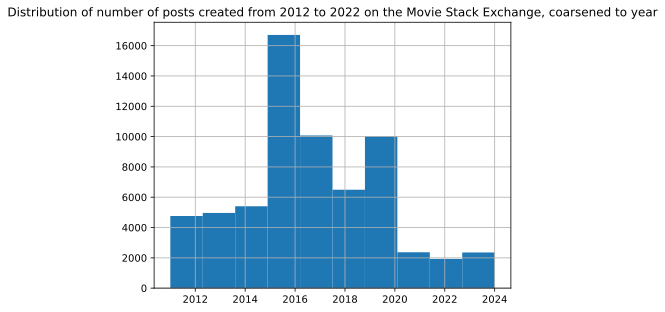

In [225]:
stack_df["CreationDate"].dt.year.hist()

plt.title('Distribution of number of posts created from 2012 to 2022 on the Movie Stack Exchange, coarsened to year')

<p>On the other hand, if we make things too granular, the plot will get very noisy. Select the right level of granularity or temporality is generally useful with time-series data.</p>

<h4>Distribution of number of posts created from 2012 to 2022 on the Movie Stack Exchange, grouped by month</h4>


Some temporal measurements are sequential, like years, and others are periodic, like months. Using the accessor object by period type allows us to look generally at which periods are more or less active. Thus, if we use dt.month over multiple years, we will get the counts for all months using value_counts(). Then we can look to see if there appear to be periodic trends by months (or seasonally).

Text(0.5, 1.0, 'Distribution of number of posts created from 2012 to 2022 on the Movie Stack Exchange, grouped by month')

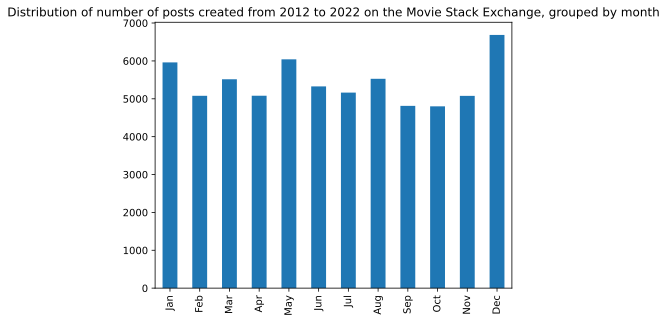

In [226]:
month_vals = stack_df["CreationDate"].dt.month.value_counts().sort_index()
month_vals.index = [calendar.month_abbr[x] for x in month_vals.index]

month_vals.plot(kind="bar");

plt.title("Distribution of number of posts created from 2012 to 2022 on the Movie Stack Exchange, grouped by month")

The figure above shows that generally there appears to be a slight in crease in December, which would coincide with the Christmas blockbuster movies.

<h4>Resampling as a way to group by time period</h4>


This is an approach to creating a DataFrame of regular periods. Here resampling our data by time is much like a groupby operation. This is especially useful if we want to compare a frequency between different days or years.

When we use df.resample(interval, on=datetime_col), we transform a DataFrame with one timestamp per row into one with even temporal intervals for the rows. If we resample by day with a dataset that ranges from 2010 to 2019, we will end up having 365 x 10 = 3650 rows, one for each row from the start to the end of the period.

Resampling is really useful when you want to have normalised plots over time. 

In [ ]:
creation_bymonth = stack_df.resample('M',on="CreationDate")
creation_byyear = stack_df.resample('Y',on="CreationDate")

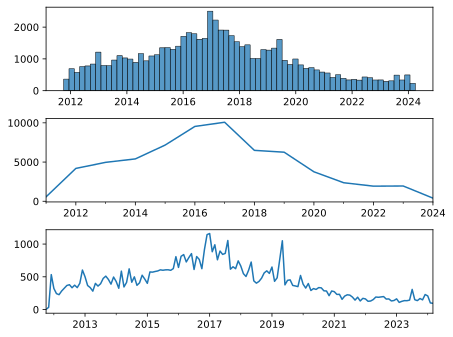

In [228]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1)

sns.histplot(stack_df["CreationDate"],
             ax=ax1).set_xlabel(None)
ax1.set_ylabel(None)

creation_byyear[["CreationDate"]].count().plot(ax=ax2, legend=False).set_xlabel(None)
ax2.set_ylabel(None)

creation_bymonth[["CreationDate"]].count().plot(ax=ax3, legend=False).set_xlabel(None)

plt.tight_layout()

plt.show()


## Moving window in data
As we saw from the time plots, some of this data is very noisy as some days might be more popular than others regardless of the general trends. In order to smooth the noise from the data, we can create a moving window that average some duration including dates before and after the specific date. This is called rolling the data.


### Set the index as a datetime object


There are several advantages to having the index as a datetime object itself. For example, rather than slicing we can use .loc and use all kinds of temporal indices.

In [229]:
# Since the index is an ID variable, we need to copy that into its own column
time_df = stack_df.copy()
time_df['Id'] = stack_df.index
time_df.set_index('CreationDate', inplace=True)
time_df[["Id", "Score"]].sample(5)

,Id,Score
CreationDate,,
2017-01-20 04:10:21.083,67205,32
2017-04-06 10:16:53.060,71306,0
2015-09-03 06:24:21.393,39687,18
2016-02-18 22:56:15.067,48986,9
2017-08-14 11:18:54.153,78777,13


With index a a datetime object, we can use .loc to query for rows by month and by range with a more succint syntax. 

In [230]:
time_df["Score"].loc['2018-03']

CreationDate
2018-03-01 00:45:31.610     0
2018-03-01 00:57:58.047     5
2018-03-01 01:57:17.737     0
2018-03-01 01:58:49.820    33
2018-03-01 02:50:11.003    47
                           ..
2018-03-31 16:36:15.423    12
2018-03-31 19:32:27.640     3
2018-03-31 20:17:43.323     2
2018-03-31 21:06:47.067     4
2018-03-31 23:14:04.987     9
Name: Score, Length: 505, dtype: int64

### Moving window


time_df["Score] has a value for each post. If we want a rolling average score, then we can select a window for how many rows we want in our window. We need to have enough data on either side of the row in order to create that window. So if we want a seven-row rolling average we can say Series.rolling(7).

In [231]:
time_df["Score7d"] = time_df["Score"].rolling(7, center=True).mean()  #center=True sets own row at the middle of that seven-row rolling average
time_df[["Score", "Score7d"]].head(10).style.format({"Score7d":"{:.2f}"})

,Score,Score7d
CreationDate,,
2011-11-30 19:15:54.070000,32,nan
2011-11-30 19:37:10.510000,15,nan
2011-11-30 19:41:14.960000,29,nan
2011-11-30 19:42:45.470000,59,25.71
2011-11-30 19:44:55.593000,16,28.14
2011-11-30 19:51:44.350000,8,31.86
2011-11-30 19:53:23.387000,21,42.86
2011-11-30 20:03:48.037000,49,36.57
2011-11-30 20:04:43.757000,41,36.29


As we set center=True, we need three rows of data first, as we cannot calculate an average of seven rows with our row in the middle until the fourth row. This explains why the first three rows of the Score7d column return NaN values.

### Resample the DataFrame by month


Because we are resampling, we are aggregating the data and thus will need a new DataFrame.

In [ ]:
time_df_month = time_df[["Score","CommentCount"]].resample("M").mean()
display(time_df_month.head(5))

The resampling ended with the finan day of each month, such as 31 October or 29 February, cleanly handling the different lengths of months. This is an avantage of resampling with datetime indices, which correctly resample by actual months rather than 30-day peridods.

In [233]:
# Resample the DataFrame by day
daily_df = time_df[["Score"]].resample('D').mean()

In [234]:
#Create 3 rolling windows by 7 days, 30 days, and 60 days
daily_df["Score7d"] = daily_df["Score"].rolling(7, center=True).mean()
daily_df["Score30d"] = daily_df["Score"].rolling(30, center=True).mean()
daily_df["Score60d"] = daily_df["Score"].rolling(60, center=True).mean()

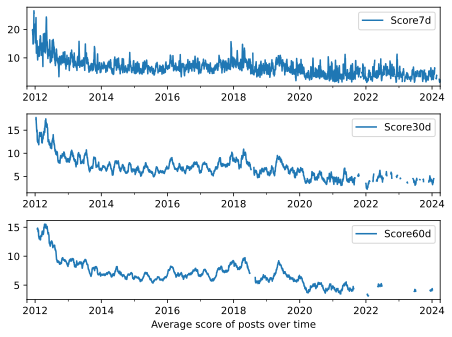

In [235]:
# Plot average score across three different-sized rolling windows: 7, 30, 60 days
fig, (ax1,ax2,ax3) = plt.subplots(3,1)

daily_df["Score7d"].plot(ax=ax1, legend=True).set_xlabel(None)
daily_df["Score30d"].plot(ax=ax2, legend=True).set_xlabel(None)
daily_df["Score60d"].plot(ax=ax3, legend=True)

ax3.set_xlabel("Average score of posts over time")
plt.tight_layout()

plt.show()



As you can see, there are periods of discontinuity in the 30-day and 60-day moving window plots. This is because the np.nan propagated into the rolling window. We can tolerate thissing data by setting a min_periods option within the rolling() method.

min_periods() is the minimum number of observations in window required to have a value; otherwise, result is np.nan.

For a window that is specified by an offset, min_periods will default to 1.

For a window that is specified by an integer, min_periods will default to the size of the window.

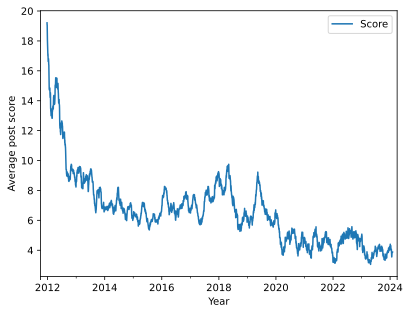

In [236]:
# Plot the rolling 60-day again with some tolerance for missing data
(daily_df["Score"]
.rolling(60, center=True, min_periods=55)
.mean()
.plot(legend=True,ylabel="Average post score", xlabel="Year"));

plt.show()

Compare to the charts above, this figure does not have the gaps in 2018 and 2021. Instead, we have a smooth rolling average that shows the score that was highest in the first year but then stabilised on average around 2014 and continued that way until 2019 once the community starts to lose interest in the site.